In [13]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer
import pandas as pd
from nltk.tokenize import word_tokenize
import re
import string
import numpy as np
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
pos_list=[]
neg_list=[]
with open("positive.txt") as fp:
    soup=BeautifulSoup(fp)
    words=soup.find_all("review_text")
    for i in range(0,len(words)-1):
        pos_list.append(words[i].string.strip('\n'))

with open("negative.txt") as fp:
    soup=BeautifulSoup(fp)
    words=soup.find_all("review_text")
    for i in range(0,len(words)-1):
        neg_list.append(words[i].string.strip('\n'))

In [16]:
amazondata=pd.read_csv("Amazon Electronics.csv")

In [17]:
amazonlist=[]
for val in amazondata['reviews']:
    amazonlist.append(val)


In [18]:
df = pd.DataFrame()
stop_words = stopwords.words('english')
porter=PorterStemmer()

def clean_data(data):
    new=[]
    newlist=[]
    for i in data:    
        i = re.sub(r"\'m", " am", i)
        i = re.sub(r"\'ve", " have", i)
        i = re.sub(r"n\'t", " not", i)
        i = re.sub(r"\'re", " are", i)
        i = re.sub(r"\'s", " is", i)
        i = re.sub(r"\'d", " would", i)
        i = re.sub(r"\'ll", " will", i)
        i = re.sub(r"(\n+)", " ", i)
        i=i.lower()
        table = str.maketrans(dict.fromkeys(string.punctuation))
        new.append(i.translate(table))
    for text in new:
        sentence=[]
        word_list=text.split(' ')
        for word in word_list:
            if word not in stop_words and word.isalpha() and len(word)>2:            
                sentence.append(porter.stem(word))
        newlist.append(' '.join(sentence))
    return newlist

cleanpos_list=clean_data(pos_list)
cleanneg_list=clean_data(neg_list)
cleanamazon_list=clean_data(amazonlist)



In [19]:
df_amazon = pd.DataFrame(cleanamazon_list)
df_amazon['sentiment']=amazondata['sentiment']
df_amazon.columns = ['reviews', 'sentiment']  
df_amazon.shape

(4000, 2)

In [20]:
df_pos = pd.DataFrame(cleanpos_list)
df_pos['sentiment'] = np.ones(len(cleanpos_list))
df_pos.columns = ['reviews', 'sentiment']

df_neg = pd.DataFrame(cleanneg_list)
df_neg['sentiment'] = np.zeros(len(cleanneg_list))
df_neg.columns = ['reviews', 'sentiment']

df = df_pos.append(df_neg,ignore_index=True)
finaldf=df.append(df_amazon,ignore_index=True)
print(finaldf.head())
print(finaldf.shape)

                                             reviews  sentiment
0  receiv kingston card advertis unit came mail e...        1.0
1  work well especi anyon still old consol system...        1.0
2  easi use larger panason use otherwis fine good...        1.0
3  work much better expect page clip also good on...        1.0
4  speedi space save inexpens bought replac belki...        1.0
(5998, 2)


In [21]:
finaldf = shuffle(finaldf)

In [22]:
X=finaldf.iloc[:,0]
y = finaldf.iloc[:,-1].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,shuffle=True,random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4798,), (4798,), (1200,), (1200,))

In [24]:
tfidfconverter = TfidfVectorizer()  
X_train = tfidfconverter.fit_transform(X_train)
X_test=tfidfconverter.transform(X_test)

In [25]:
X_train.shape

(4798, 9429)

In [26]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

# XGBoost

In [30]:
pipe = Pipeline(steps=[('fclasif',SelectKBest(f_classif,k=100)),('xgb', XGBClassifier())])

# prepare a prameter grid

param_grid = {
    'xgb__learning_rate'    : [ 0.10,  0.20, 0.30 ] ,
    'xgb__max_depth'        : [ 10, 20, 30],
    'xgb__min_child_weight' : [ 1, 3, 5, 7 ],
    'xgb__gamma'            : [ 0.0, 0.1, 0.2 , 0.3 ],
    'xgb__colsample_bytree' : [ 0.5 , 0.7 , 0.9 ]
}

search = GridSearchCV(pipe, param_grid, cv=5, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
XGB_best_params = search.best_params_
XGB_best_model = search.best_estimator_
test_pred = XGB_best_model.predict(X_test)

Best CV score = 0.831:
Best parameters:  {'xgb__colsample_bytree': 0.7, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 10, 'xgb__min_child_weight': 1}


In [16]:
XGB_accuracy, XGB_precision, XGB_recall, XGB_f1_score, XGB_tpr,XGB_auc = evaluate_model(X_test, y_test, XGB_best_model)
print("XGB__Accuracy: {:.5f}".format(XGB_accuracy))
print("XGB_precision: {:.5f}".format(XGB_precision))
print("XGB_recall: {:.5f}".format(XGB_recall))
print("XGB_f1_score: {:.5f}".format(XGB_f1_score))

XGB__Accuracy: 0.83667
XGB_precision: 0.88113
XGB_recall: 0.77833
XGB_f1_score: 0.82655


C:\Users\Jithu\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


# SVM

In [28]:
pipe = Pipeline(steps=[('fclasif',SelectKBest(f_classif,k=100)),('svm', svm.SVC(probability=True))])

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, cv=5, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_
test_pred = SVM_best_model.predict(X_test)

Best CV score = 0.835:
Best parameters:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [18]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr,SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
print("SVM__Accuracy: {:.5f}".format(SVM_accuracy))
print("SVM_precision: {:.5f}".format(SVM_precision))
print("SVM_recall: {:.5f}".format(SVM_recall))
print("SVM__f1_score: {:.5f}".format(SVM_f1_score))

SVM__Accuracy: 0.83750
SVM_precision: 0.89168
SVM_recall: 0.76833
SVM__f1_score: 0.82543


C:\Users\Jithu\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


# Bar Plot

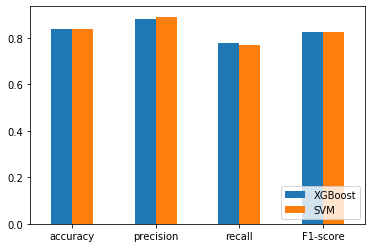

In [19]:
XGB_metrics = np.array([XGB_accuracy, XGB_precision, XGB_recall, XGB_f1_score])
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'XGBoost': XGB_metrics,'SVM': SVM_metrics }, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

# ROC Curve

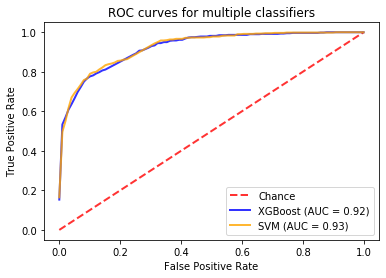

In [20]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, XGB_tpr[0,:], lw=2, color='blue', label='XGBoost (AUC = %0.2f)' % (XGB_auc), alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='orange', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()